# Set-Up

In [1]:
import os

#os.environ["CUDA_DEVICE_ORDER"]= "01:00.0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import wandb
wandb.login()
%env WANDB_LOG_MODEL=true

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iq000012 (infinitasfish). Use `wandb login --relogin` to force relogin


env: WANDB_LOG_MODEL=true


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image, ImageDraw, ImageOps
import json
import os
import datasets
import matplotlib.pyplot as plt
import math
#from pdf2image import convert_from_path

In [4]:
print(torch.cuda.is_available(), torch.cuda.device_count())
print(torch.cuda.current_device())

True 1
0


In [5]:
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass


def order_boxes(boxes):
    def contour_dist(box1, box2):
        def axiswise_dist(s1, s2):
            """
            s = (left coord, right coord)
            """
            left = min(s1, s2, key=lambda x: x[0])
            right = max(s1, s2, key=lambda x: x[0])

            return max(0, right[0] - left[1])

        delta_x = axiswise_dist((box1[0], box1[0] + box1[2]), (box2[0], box2[0] + box2[2]))
        delta_y = axiswise_dist((box1[1], box1[1] + box1[3]), (box2[1], box2[1] + box2[3]))

        if delta_x == delta_y == 0:
            return 0
        if min(delta_x, delta_y) == 0 and max(delta_x, delta_y) > 0:
            return max(delta_x, delta_y)
        return math.sqrt(delta_x * delta_x + delta_y * delta_y)

    y_sorted_boxes = np.array(sorted(boxes.copy(), key=lambda x: x[1]), dtype='int64')
    indices = np.array([i for i, box in sorted(enumerate(boxes.copy()), key=lambda x:x[1][1])])

    epsilon = np.mean(boxes[:, 3])

    cluster_labels = np.full((len(y_sorted_boxes, )), fill_value=-1)

    cluster_labels[0] = 0

    for i in range(len(y_sorted_boxes)):
        if cluster_labels[i] == -1:
            cluster_labels[i] = max(cluster_labels) + 1
        for j in range(len(y_sorted_boxes)):
            if contour_dist(y_sorted_boxes[i], y_sorted_boxes[j]) < epsilon:
                min_l = min(cluster_labels[i], cluster_labels[j])
                max_l = max(cluster_labels[i], cluster_labels[j])
                if min_l == -1:
                    cluster_labels[i] = max_l
                    cluster_labels[j] = max_l
                    continue
                cluster_labels[cluster_labels == max_l] = min_l

    cluster_labels = np.array(cluster_labels)

    sorted_boxes = list()
    sorted_indices = list()
    for c in np.unique(cluster_labels):
        cluster_boxes = y_sorted_boxes[cluster_labels == c]
        cluster_indices = indices[cluster_labels == c]
        
        group = [cluster_boxes[0]]
        indices_group = [cluster_indices[0]]
        for i in range(1, len(cluster_boxes)):
            if abs(cluster_boxes[i][1] - cluster_boxes[i - 1][1]) < (epsilon*0.5):
                group.append(cluster_boxes[i])
                indices_group.append(cluster_indices[i])
            else:
                sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
                sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])
                
                group = [cluster_boxes[i]]
                indices_group = [cluster_indices[i]]
                
        sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
        sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])

    sorted_boxes = np.array([np.array(box) for box in sorted_boxes])
    return np.array(sorted_indices), sorted_boxes

# Data Extraction from Annotations

In [6]:
annotation_path = Path('fixed_receipts_2506.json')

with open(annotation_path, 'r') as annotation_f:
  annotation_list = json.load(annotation_f)

type(annotation_list), len(annotation_list)

(list, 180)

In [7]:
labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-COMPANY': 1,
 'I-COMPANY': 2,
 'B-DATE': 3,
 'I-DATE': 4,
 'B-ADDRESS': 5,
 'I-ADDRESS': 6,
 'B-TOTAL': 7,
 'I-TOTAL': 8}

In [8]:
# converts ls normalized boxes to pixels, returns coord. for top-left and bottom-right

def unnormalize_ls_box(result):
  value = result['value']
  orig_w, orig_h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = orig_w * value['x'] / 100.0, orig_h * value['y'] / 100.0
    # x1, y1 = x0 + orig_w * value['width'] / 100.0, y0 + orig_h * value['height'] / 100.0
    w, h = orig_w * value['width'] / 100.0, orig_h * value['height'] / 100.0
    return [x0, y0, w, h]

In [9]:
# gets formatted data from ls json file for 1 task
# ex = {image: [...], words: [...], boxes: [...], ner_tags: [...]}

def format_ls_anns(receipt_ann, ds_path, label2id):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  if os.path.exists(os.path.join(ds_path, image_name)):
    pil_im = Image.open(os.path.join(ds_path, image_name))
    pil_im = ImageOps.exif_transpose(pil_im)
    image_np = np.array(pil_im)
    # for sorting purposes :)
    formatted_ex['image_name'] = image_name  
      
    formatted_ex['image'] = image_np

    formatted_ex['boxes'] = np.array([unnormalize_ls_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)
    # sorting boxes and accordingly to them words, ner_tags for better training
    permutation, formatted_ex['boxes'] = order_boxes(formatted_ex['boxes'])
    for i, box in enumerate(formatted_ex['boxes']): # converting boxes to corners x0, y0, x2, y2
        x0, y0, w, h = box
        formatted_ex['boxes'][i] = np.array([x0, y0, x0+w, y0+h])
      
    formatted_ex['words'] = [ann['value']['text'][0].upper() for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))
    formatted_ex['words'] = np.array([formatted_ex['words'][i] for i in permutation])
      
    formatted_ex['ner_tags'] = [label2id[ann['value']['labels'][0]] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'labels']
    formatted_ex['ner_tags'] = np.squeeze(np.array(formatted_ex['ner_tags']))
    formatted_ex['ner_tags'] = np.array([formatted_ex['ner_tags'][i] for i in permutation])

    assert len(formatted_ex['boxes']) == len(formatted_ex['words']) == len(formatted_ex['ner_tags']) == len(permutation)
      
    return formatted_ex
      
  else:
    # print(image_name)
    return None

In [10]:
# checking result shapes after formatting

example_ = annotation_list[-2]

image_ds_path = Path('all_images')
example_cleared = format_ls_anns(example_, image_ds_path, label2id)

print(example_cleared['image'].shape, 
      example_cleared['words'].shape, example_cleared['boxes'].shape, 
      example_cleared['ner_tags'].shape)

(812, 331, 3) (216,) (216, 4) (216,)


In [11]:
# getting dataset of all examples

train_dataset_path = Path('train_split')
val_dataset_path = Path('val_split')

train_dataset_clear = []
val_dataset_clear = []

for ann in annotation_list:
    data = format_ls_anns(ann, ds_path=train_dataset_path, label2id=label2id)
    if data is not None:
        train_dataset_clear.append(data)

for ann in annotation_list:
    data = format_ls_anns(ann, ds_path=val_dataset_path, label2id=label2id)
    if data is not None:
        val_dataset_clear.append(data)
        
train_dataset_clear = sorted(train_dataset_clear, key=lambda d: d['image_name'])
val_dataset_clear = sorted(val_dataset_clear, key=lambda d: d['image_name'])

print(f'train len {len(train_dataset_clear)}, val len {len(val_dataset_clear)}')

train len 149, val len 31


In [12]:
# model accepts boxes in range 0..1000 

def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]

In [13]:
def normalize_boxes_of_data(data):
  hw = data['image'].shape
  for i, box in enumerate(data['boxes']):
    #
    norm_box = normalize_box_1000(box, hw[0], hw[1])
    data['boxes'][i] = norm_box

In [14]:
for data in train_dataset_clear:
  normalize_boxes_of_data(data)

for data in val_dataset_clear:
  normalize_boxes_of_data(data)

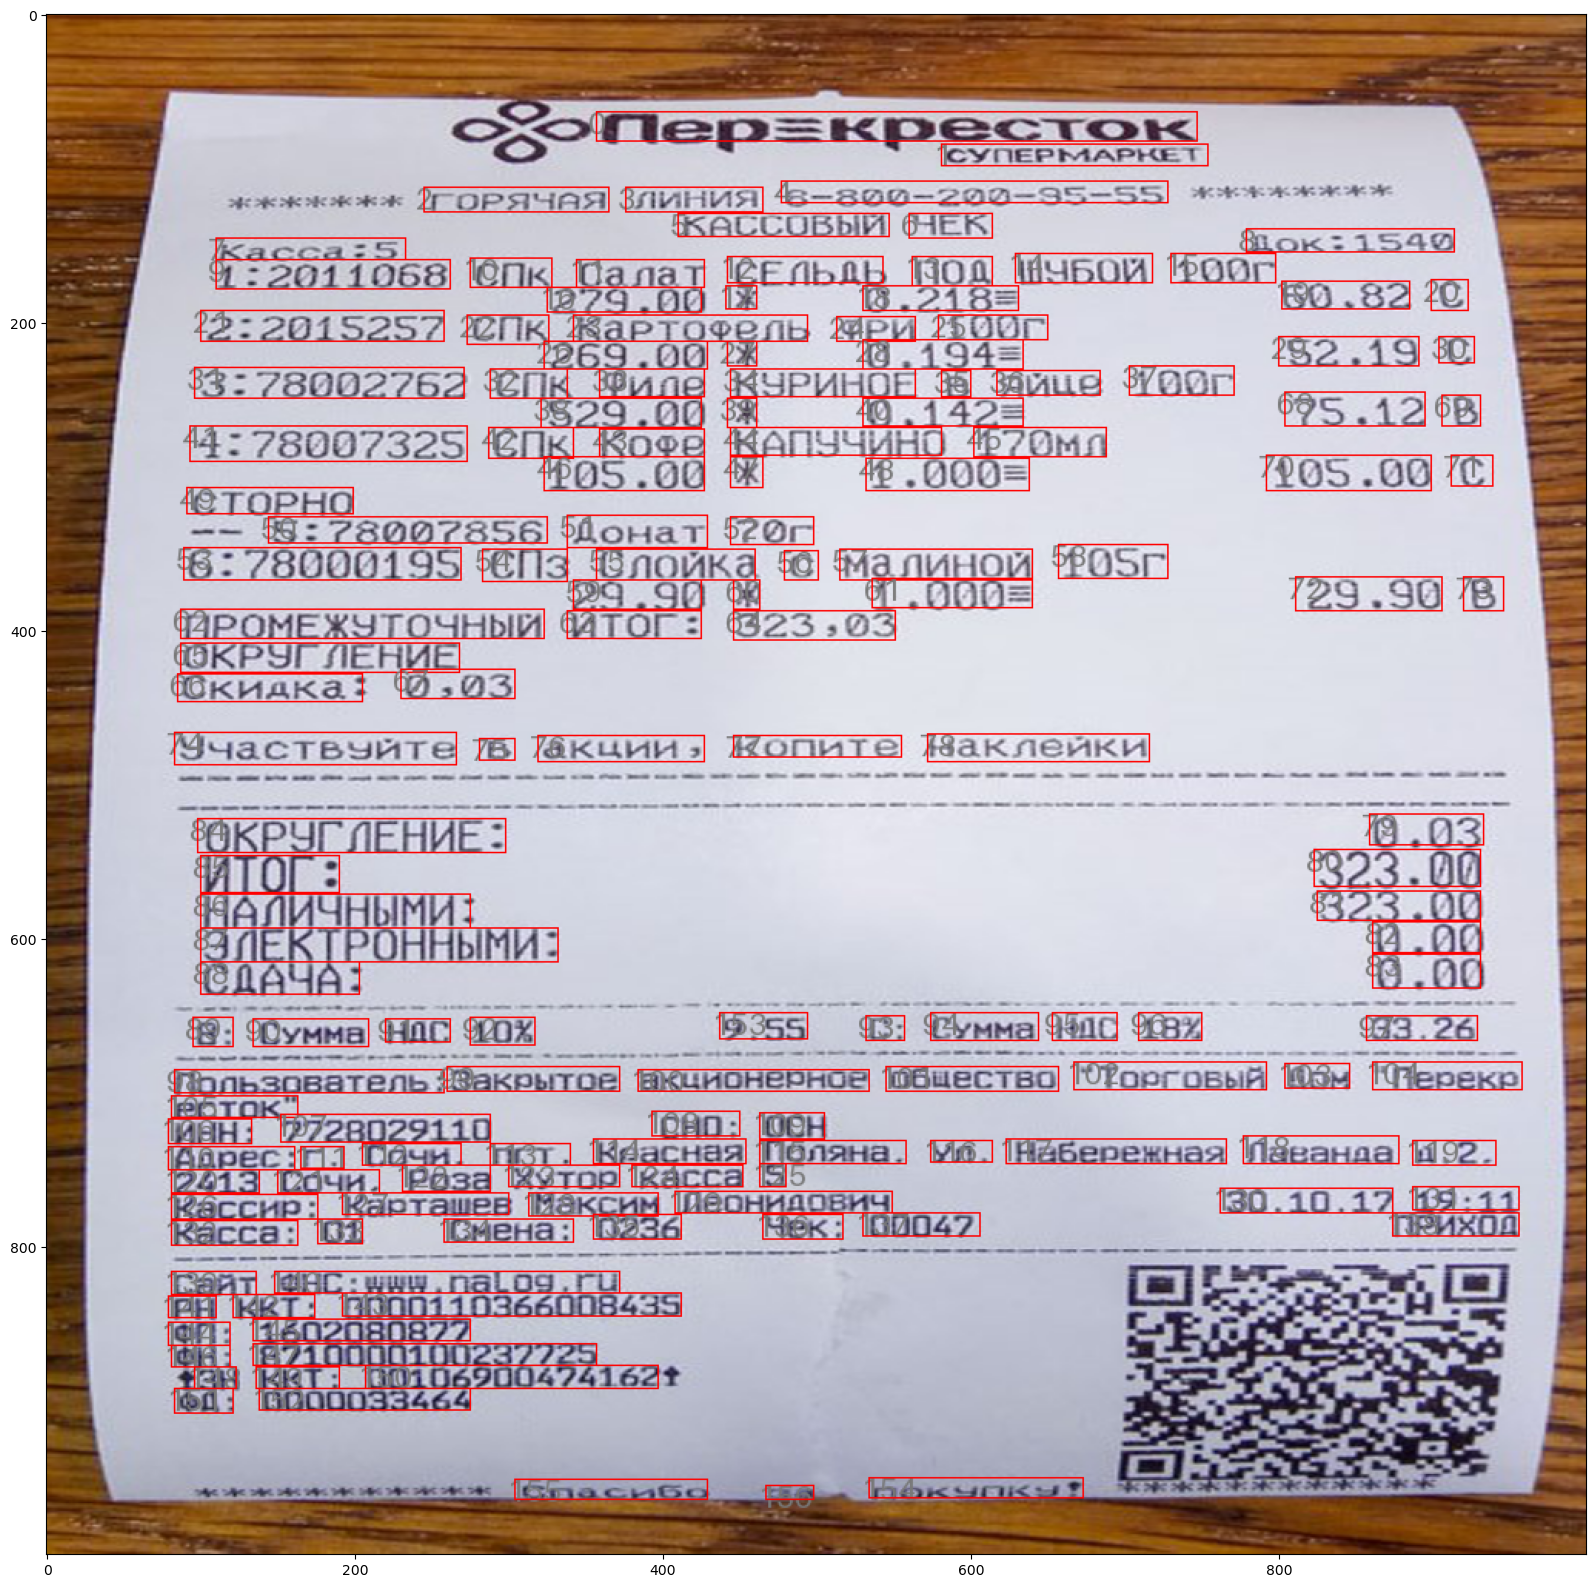

In [15]:
example = train_dataset_clear[9]
image = Image.fromarray(example['image']).resize((1000, 1000))
image_draw = ImageDraw.Draw(image)

for i, box in enumerate(example['boxes']):
  image_draw.text((box[0]-5, box[1]-5), str(i), fill=(120, 120, 120), font_size=20)
  image_draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')

plt.figure(figsize=(20,20))
plt.imshow(image)

# Train Dataset Preparation ..zZz..

In [16]:
labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-COMPANY': 1,
 'I-COMPANY': 2,
 'B-DATE': 3,
 'I-DATE': 4,
 'B-ADDRESS': 5,
 'I-ADDRESS': 6,
 'B-TOTAL': 7,
 'I-TOTAL': 8}

In [17]:
# copying datasets, but I don't really know why lol
train_ds_copy = train_dataset_clear.copy()
val_ds_copy = val_dataset_clear.copy()

In [18]:
# adding third dimension for grayscale images
def get_third_dim(ds_image):
  return np.dstack((ds_image, ds_image, ds_image))

# removing fourth dimension for some png images
def remove_fourth_dim(ds_image):
  return ds_image[:,:,:3]

for i, ex in enumerate(train_ds_copy):
  if len(ex['image'].shape) == 2:
    print(i)
    train_ds_copy[i]['image'] = get_third_dim(train_ds_copy[i]['image'])
    print(f"after adding: {train_ds_copy[i]['image'].shape}")

for i, ex in enumerate(val_ds_copy):
  if len(ex['image'].shape) == 2:
    print(i)
    val_ds_copy[i]['image'] = get_third_dim(val_ds_copy[i]['image'])
    print(f"after adding: {val_ds_copy[i]['image'].shape}")

89
after adding: (2339, 1653, 3)


In [19]:
for i, ex in enumerate(train_ds_copy):
  if ex['image'].shape[2] == 4:
    print(i)
    train_ds_copy[i]['image'] = remove_fourth_dim(train_ds_copy[i]['image'])
    print(f"after removing: {train_ds_copy[i]['image'].shape}")

for i, ex in enumerate(val_ds_copy):
  if ex['image'].shape[2] == 4:
    print(i)
    val_ds_copy[i]['image'] = remove_fourth_dim(val_ds_copy[i]['image'])
    print(f"after removing: {val_ds_copy[i]['image'].shape}")

90
after removing: (1264, 1507, 3)


In [20]:
# adding 'image_shape' field for retrieving original shape later

for i in range(len(train_dataset_clear)):
  train_ds_copy[i]['image_shape_h_w_d'] = list(train_dataset_clear[i]['image'].shape)
    
for i in range(len(val_dataset_clear)):
  val_ds_copy[i]['image_shape_h_w_d'] = list(val_dataset_clear[i]['image'].shape)

In [21]:
train_ds_copy[0]['image_shape_h_w_d'], val_ds_copy[0]['image_shape_h_w_d']

([1528, 1170, 3], [1420, 1065, 3])

In [22]:
def flat_ds_data(ds):
  ds_copy = ds.copy()

  for i in range(len(ds)):
    for key, value in ds[i].items():
      if isinstance(value, np.ndarray):
        ds_copy[i][key] = ds_copy[i][key].flatten()
      ds_copy[i][key] = np.asarray(ds_copy[i][key])

  return ds_copy

In [23]:
train_flatten_ds = flat_ds_data(train_ds_copy)
val_flatten_ds = flat_ds_data(val_ds_copy)

for key, value in val_flatten_ds[3].items():
  print(key, value)

for data_dict in train_flatten_ds:
    del data_dict['image_name']
    
for data_dict in val_flatten_ds:
    del data_dict['image_name']

image_name 20240304_182144.jpg
image [162 133  91 ...  52  32  21]
boxes [278 118 331 133 349 114 516 132 536 113 655 128 242 136 388 151 415 133
 635 149 661 131 698 146 135 195 185 212 202 193 345 210 539 190 618 206
 628 190 717 205 132 215 184 231 202 213 392 230 553 212 616 227 629 210
 791 225 130 236 226 250 236 235 305 250 322 235 420 250 429 232 535 248
 554 232 618 248 626 229 845 248 128 255 163 271 180 256 321 273 342 255
 368 272 391 255 420 271 556 253 618 268 628 250 845 267 270 275 375 292
 412 273 661 291 321 295 482 312 500 295 642 313 119 319 239 332 250 322
 349 333 363 318 391 333 408 318 452 332 118 340 235 354 248 341 270 354
 286 341 311 355 116 363 312 375 623 337 756 353 773 337 837 351 570 361
 611 375 626 360 839 375 115 405 261 421 277 405 429 422 442 405 479 422
 494 404 594 422 610 405 685 421 702 403 852 421 112 427 180 443 295 426
 404 445 460 428 571 444 720 425 838 442 112 449 257 467 273 450 372 468
 384 448 590 466 608 448 822 466 834 450 861 466 10

In [24]:
# converting list of dictionaries to transformers Dataset by using pandas df

train_df = pd.DataFrame.from_dict(train_flatten_ds)
val_df = pd.DataFrame.from_dict(val_flatten_ds)
print(type(val_df.iloc[0]['image']))

<class 'numpy.ndarray'>


In [25]:
t_train_dataset = datasets.Dataset.from_pandas(train_df)
t_val_dataset = datasets.Dataset.from_pandas(val_df)

t_train_dataset, t_val_dataset

(Dataset({
     features: ['image', 'boxes', 'words', 'ner_tags', 'image_shape_h_w_d'],
     num_rows: 149
 }),
 Dataset({
     features: ['image', 'boxes', 'words', 'ner_tags', 'image_shape_h_w_d'],
     num_rows: 31
 }))

In [28]:
#t_val_dataset.save_to_disk('receipts_validation_bef_processor')

In [29]:

# compiling into single DatasetDict
train_valid_dataset = datasets.DatasetDict({
    'train': t_train_dataset,
    'valid': t_val_dataset})

In [30]:
train_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'boxes', 'words', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 149
    })
    valid: Dataset({
        features: ['image', 'boxes', 'words', 'ner_tags', 'image_shape_h_w_d'],
        num_rows: 31
    })
})

In [29]:
from transformers import LayoutXLMProcessor

with no_ssl_verification():
    processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
# func for Datasets.map(), handle multiple all rows at once

def prepare_examples(examples):
  # ugly aaaahhhhware
  h_ws, images, boxes, labels = [], [], [], []

  for shape in examples['image_shape_h_w_d']:
    h_ws.append(shape[:2])

  for i, image in enumerate(examples['image']):
    images.append(np.asarray(image).reshape(h_ws[i][0], h_ws[i][1], 3))

  words = examples['words']

  for box in examples['boxes']:
    boxes.append(np.asarray(box).reshape(-1, 4))

  for tags in examples['ner_tags']:
    labels.append(np.asarray(tags))

  encoding = processor(images, words, boxes=boxes, word_labels=labels,
                       truncation=True, padding="max_length", max_length=512)

  return encoding

In [31]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

column_names = train_valid_dataset['train'].column_names

t_train_dataset = train_valid_dataset['train'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/149 [00:00<?, ? examples/s]

In [32]:
t_valid_dataset = train_valid_dataset['valid'].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/31 [00:00<?, ? examples/s]

In [33]:
t_train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [34]:
t_valid_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 31
})

In [35]:
# saving val_dataset to disk
# t_valid_dataset.save_to_disk('receipts_validation_after_procsr')

In [36]:
example = t_train_dataset[10]
processor.tokenizer.decode(example["input_ids"])

'<s> КАССОВЫЙ ЧЕК No 4282 05.01.2024 21:54 HTTPS://WWW.OZON.RU/ ИНТЕРНЕТ РЕШЕНИЯ, ООО ИНН 7704217370 ВИД НАЛОГООБЛОЖЕНИЯ: ОСН ПРИХОД МОДУЛЬ В510-08 ДЛЯ АКВАФОР ТРИО (ДЛЯ ВОДЫ С ПОВЫШЕННЫМ СОДЕРЖАНИЕМ ЖЕЛЕЗА), 522205 (208323) АКВАФОР 1 X 890,00 БЕЗ НДС ИНН ПРОДАВЦА: 780612217049 ЛАПОТЬКО ЮЛИЯ, ИП 1. =890,00 =890,00 2. МОДУЛЬ КАРТРИДЖ В510-04 ДЛЯ ТРИО, ДУЭТ, УМЯГЧАЮЩИЙ, 100669 АКВАФОР 1 X 972,00 БЕЗ НДО ИНН ПРОДАВЦА: 780612217049 ЛАПОТЬКО ЮЛИЯ, ИП =972,00 =972,00 КАРТРИДЖ 1 ШТ ДЛЯ ФИЛЬТРА ВОДЫ ПОЛИПРОПИЛЕН 10SL, 5 МКМ, БРЕНД RND 1 X 150,00 БЕЗ НДС ИНН ПРОДАВЦА: 6166127411 ООО "ДОН-ФИЛЬТР", ООО 3. =150,00 =150,00 ИТОГ БЕЗ НДС ПРЕДВАРИТЕЛЬНАЯ ОПЛАТА БЕЗНАЛИЧНЫМИ =2012,00 =2012,00 =2012,00 7281440701383850 0006001987042002 161338 2659395900 WWW.NALOG.RU ФН: PH ККТ: ФД: ФПД: САЙТ ФНС:</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [37]:
for id, label in zip(t_train_dataset[10]["input_ids"][:30], t_train_dataset[10]["labels"][:30]):
  print(processor.tokenizer.decode([id]), label)

<s> -100
КА 0
СС -100
ОВ -100
ЫЙ -100
Ч 0
ЕК -100
No 0
42 0
82 -100
05 3
.01. -100
20 -100
24 -100
21 0
:54 -100
HTTP 5
S -100
:// -100
W -100
WW -100
. -100
O -100
ZON -100
. -100
RU -100
/ -100
ИН 1
ТЕР -100
НЕТ -100


In [38]:
t_train_dataset.set_format("torch")
t_valid_dataset.set_format("torch")

In [39]:
# so fine
example = t_valid_dataset[0]
for k,v in example.items():
    print(k,v.shape)

image torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Define Metrics

In [40]:
from datasets import load_metric

metric = load_metric("seqeval")

/tmp/ipykernel_3554702/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [41]:
label_list = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label

{0: 'O',
 1: 'B-COMPANY',
 2: 'I-COMPANY',
 3: 'B-DATE',
 4: 'I-DATE',
 5: 'B-ADDRESS',
 6: 'I-ADDRESS',
 7: 'B-TOTAL',
 8: 'I-TOTAL'}

In [42]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions_with_O = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels_with_O = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_predictions_wout_O = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100 and l != 0]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels_wout_O = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100 and l != 0]
        for prediction, label in zip(predictions, labels)
    ]

    results_wout_O =  metric.compute(predictions=true_predictions_wout_O, references=true_labels_wout_O)   
    results_with_O = metric.compute(predictions=true_predictions_with_O, references=true_labels_with_O)
    
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results_with_O["overall_precision"],
            "recall": results_with_O["overall_recall"],
            "f1": results_with_O["overall_f1"],
            "accuracy": results_with_O["overall_accuracy"],
            
            "precision_wout_O": results_wout_O["overall_precision"] ,
            "recall_wout_O": results_wout_O["overall_recall"],
            "f1_wout_O": results_wout_O["overall_f1"],
            "accuracy_wout_O": results_wout_O["overall_accuracy"],
        }

# Load XLM Model Checkpoint, Initialize Trainer

In [44]:
# import gc

# del model

# gc.collect()
# torch.cuda.empty_cache()

In [45]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutxlm-base",
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         num_labels=len(label_list))

# model.to(device);

/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutxlm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able 

In [46]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  num_train_epochs=100,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  learning_rate=1e-5,
                                  warmup_steps=350,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  save_total_limit=5,
                                  load_best_model_at_end=True,                          
                                  metric_for_best_model="f1",
                                  report_to='wandb',)
training_args.device

comet_ml is installed but `COMET_API_KEY` is not set.


device(type='cuda', index=0)

In [48]:
from transformers.data.data_collator import default_data_collator
from transformers import EarlyStoppingCallback

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=15)],
)

# Train

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Precision Wout O,Recall Wout O,F1 Wout O,Accuracy Wout O
1,No log,1.449621,0.013158,0.004082,0.006231,0.789975,0.045455,0.004329,0.007905,0.000000
2,No log,0.769985,0.000000,0.000000,0.000000,0.805657,0.000000,0.000000,0.000000,0.000000
3,No log,0.407403,0.345070,0.200000,0.253230,0.878745,0.403361,0.207792,0.274286,0.417867
4,No log,0.239009,0.655814,0.575510,0.613043,0.929712,0.826590,0.619048,0.707921,0.753602
5,No log,0.163817,0.733906,0.697959,0.715481,0.946794,0.863636,0.740260,0.797203,0.821326
6,No log,0.119171,0.803279,0.800000,0.801636,0.966396,0.908257,0.857143,0.881960,0.896254
7,No log,0.107336,0.852459,0.848980,0.850716,0.970596,0.945455,0.900433,0.922395,0.907781
8,No log,0.163075,0.900943,0.779592,0.835886,0.962195,0.940887,0.826840,0.880184,0.838617
9,No log,0.096226,0.878661,0.857143,0.867769,0.972557,0.950000,0.904762,0.926829,0.904899
10,No log,0.097412,0.861789,0.865306,0.863544,0.975077,0.942222,0.917749,0.929825,0.927954


/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vshishaev/anaconda

TrainOutput(global_step=1026, training_loss=0.1580473387189079, metrics={'train_runtime': 609.6226, 'train_samples_per_second': 24.441, 'train_steps_per_second': 6.233, 'total_flos': 2171873537307648.0, 'train_loss': 0.1580473387189079, 'epoch': 27.0})

# Saving and Eval

In [50]:
# saving this fine-tuned on rus receipts checkpoint
trainer.save_model('layout_checks/layoutXLM_rus_only_0707')

In [43]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("layout_checks/layoutXLM_sroie_rus_ordered_2506",
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         num_labels=len(label_list))

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t_train_dataset,
    eval_dataset=t_valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [53]:
# v0
trainer.evaluate()

{'eval_loss': 0.08597315847873688,
 'eval_precision': 0.8958333333333334,
 'eval_recall': 0.8775510204081632,
 'eval_f1': 0.8865979381443299,
 'eval_accuracy': 0.9798375805096612,
 'eval_precision_wout_O': 0.9641255605381166,
 'eval_recall_wout_O': 0.9307359307359307,
 'eval_f1_wout_O': 0.947136563876652,
 'eval_accuracy_wout_O': 0.9365994236311239,
 'eval_runtime': 0.9838,
 'eval_samples_per_second': 31.51,
 'eval_steps_per_second': 8.132}

In [ ]:
import os
import signal

os.kill(os.getpid(), signal.SIGTERM)

# Calc Metrics 

In [44]:

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
device = 'cpu';
for encoding in t_valid_dataset:
    with torch.inference_mode():

        for k,v in encoding.items():
          encoding[k] = v.unsqueeze(0).to(device)
        
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                bbox=encoding['bbox'], image=encoding['image'])
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = encoding["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, encoding["labels"].detach().cpu().numpy(), axis=0)

preds_val.shape, out_label_ids.shape

((31, 512, 9), (31, 512))

In [45]:
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, label_map):
  preds = np.argmax(preds, axis=2)

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])              

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [47]:
# best model so far layoutXLM_sroie_rus_ordered_2506 (rus + sroie)

val_result, class_report = results_test(preds_val, out_label_ids, id2label)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9601769911504425, 'recall': 0.8857142857142857, 'f1': 0.9214437367303608}
              precision    recall  f1-score   support

     ADDRESS       0.91      0.67      0.77        58
     COMPANY       0.93      0.86      0.90        50
        DATE       0.97      1.00      0.99        38
       TOTAL       0.99      0.98      0.98        99

   micro avg       0.96      0.89      0.92       245
   macro avg       0.95      0.88      0.91       245
weighted avg       0.96      0.89      0.92       245



In [52]:
# only rus trained layoutXLM_rus_only_0707

val_result, class_report = results_test(preds_val, out_label_ids, id2label)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.8958333333333334, 'recall': 0.8775510204081632, 'f1': 0.8865979381443299}
              precision    recall  f1-score   support

     ADDRESS       0.80      0.60      0.69        58
     COMPANY       0.88      0.88      0.88        50
        DATE       0.97      1.00      0.99        38
       TOTAL       0.92      0.99      0.95        99

   micro avg       0.90      0.88      0.89       245
   macro avg       0.89      0.87      0.88       245
weighted avg       0.89      0.88      0.88       245

